# Cash/3Mスプレッド分析 1: スプレッドカーブダイナミクス

## 概要
本ノートブックでは、LME銅のCash/3Mスプレッドの時系列動態を分析します。
Cash/3Mスプレッド = Cash価格 - 3M先物価格として定義され、市場の需給状況を反映します。

## 目次
1. [データの読み込みと前処理](#1-データの読み込みと前処理)
2. [基本統計と時系列特性](#2-基本統計と時系列特性)
3. [スプレッドカーブの形状分析](#3-スプレッドカーブの形状分析)
4. [バックワーデーション/コンタンゴ分析](#4-バックワーデーション/コンタンゴ分析)
5. [季節性とトレンド分析](#5-季節性とトレンド分析)
6. [まとめ](#6-まとめ)

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import warnings
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. データの読み込みと前処理

PostgreSQLデータベースからCash/3Mスプレッドデータと関連する先物価格データを読み込みます。

In [39]:
# データベース設定と接続
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# SQLAlchemy接続文字列作成
user = db_config['user']
password = db_config['password']
host = db_config['host']
port = db_config['port']
database = db_config['database']
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"
engine = create_engine(connection_string)

print("データベース接続設定完了")

データベース接続設定完了


In [40]:
# Cash/3Mスプレッドデータの読み込み
def load_spread_data():
    """PostgreSQLからCash/3Mスプレッドデータを読み込み"""
    try:
        # まず接続テスト
        test_query = "SELECT 1"
        test_result = pd.read_sql_query(test_query, engine)
        print("データベース接続テスト成功")
        
        # テーブル存在確認
        table_check_query = """
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public' 
        AND table_name IN ('lme_copper_futures', 'lme_copper_prices')
        """
        table_result = pd.read_sql_query(table_check_query, engine)
        print(f"利用可能なテーブル: {table_result['table_name'].tolist()}")
        
        if table_result.empty:
            raise Exception("LME銅データテーブルが見つかりません")
        
        # 複数のデータソースを試行
        queries_to_try = [
            # 1. lme_copper_futuresからCMCU0-3を直接取得
            {
                'name': 'CMCU0-3 スプレッドデータ',
                'query': """
                SELECT 
                    trade_date,
                    ric,
                    close_price as spread_price,
                    volume
                FROM lme_copper_futures
                WHERE ric = 'CMCU0-3'
                    AND close_price IS NOT NULL
                ORDER BY trade_date
                """
            },
            # 2. Cash価格と3M価格から計算
            {
                'name': 'Cash-3M計算スプレッド',
                'query': """
                WITH cash_data AS (
                    SELECT 
                        trade_date,
                        close_price as cash_price
                    FROM lme_copper_futures
                    WHERE ric = 'CMCU0'
                        AND close_price IS NOT NULL
                ),
                three_month_data AS (
                    SELECT 
                        trade_date,
                        close_price as three_month_price
                    FROM lme_copper_futures
                    WHERE ric = 'CMCU3'
                        AND close_price IS NOT NULL
                )
                SELECT 
                    c.trade_date,
                    'CMCU0-3' as ric,
                    (c.cash_price - t.three_month_price) as spread_price,
                    COALESCE(c.cash_price, 0) as volume
                FROM cash_data c
                INNER JOIN three_month_data t ON c.trade_date = t.trade_date
                ORDER BY c.trade_date
                """
            },
            # 3. lme_copper_pricesからスプレッドデータ
            {
                'name': 'Price tableからスプレッド',
                'query': """
                SELECT 
                    trade_date,
                    'CASH_3M_SPREAD' as ric,
                    last_price as spread_price,
                    volume
                FROM lme_copper_prices
                WHERE price_type = 'CASH_3M_SPREAD'
                    AND last_price IS NOT NULL
                ORDER BY trade_date
                """
            }
        ]
        
        df = None
        for query_info in queries_to_try:
            try:
                print(f"試行中: {query_info['name']}")
                df = pd.read_sql_query(query_info['query'], engine)
                if not df.empty:
                    print(f"成功: {query_info['name']} - {len(df)}レコード取得")
                    break
                else:
                    print(f"データなし: {query_info['name']}")
            except Exception as query_error:
                print(f"クエリエラー ({query_info['name']}): {query_error}")
                continue
        
        if df is None or df.empty:
            raise Exception("全てのクエリでデータ取得に失敗")
        
        # データ前処理
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        
        print(f"スプレッドデータ読み込み完了: {len(df):,}件のレコード")
        print(f"期間: {df.index.min()} ～ {df.index.max()}")
        
        return df
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        print(f"エラータイプ: {type(e).__name__}")
        
        # ダミーデータを作成
        print("ダミーデータを作成します...")
        
        # ダミーのCash/3Mスプレッドデータを生成
        start_date = datetime(2020, 1, 1)
        end_date = datetime(2024, 12, 31)
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # 営業日のみ
        
        # リアルなスプレッドデータのシミュレーション
        np.random.seed(42)
        n_days = len(date_range)
        
        # 基本トレンド + 季節性 + ランダムウォーク
        trend = np.linspace(-20, 30, n_days)
        seasonal = 15 * np.sin(2 * np.pi * np.arange(n_days) / 260)  # 年間営業日ベース
        noise = np.random.normal(0, 25, n_days)
        random_walk = np.cumsum(np.random.normal(0, 5, n_days))
        
        spread_prices = trend + seasonal + noise + random_walk * 0.3
        
        # データフレームの作成
        df = pd.DataFrame({
            'ric': 'CMCU0-3',
            'spread_price': spread_prices,
            'volume': np.random.lognormal(8, 1, n_days).astype(int)
        }, index=date_range)
        
        print(f"ダミーデータを作成しました: {len(df)}レコード")
        print("注意: これはダミーデータです。実際の分析には本物のデータベース接続が必要です。")
        
        return df

# データ読み込み
spread_data = load_spread_data()

if spread_data is not None:
    print(f"\nデータ概要:")
    print(f"- 総レコード数: {len(spread_data):,}")
    print(f"- 期間: {len(spread_data)} 取引日")
    print(f"\n基本統計:")
    print(spread_data['spread_price'].describe())
    print(f"\nデータサンプル:")
    print(spread_data.head())
else:
    print("データの読み込みに失敗しました")

データベース接続テスト成功
利用可能なテーブル: ['lme_copper_futures', 'lme_copper_prices']
試行中: CMCU0-3 スプレッドデータ
データなし: CMCU0-3 スプレッドデータ
試行中: Cash-3M計算スプレッド
データなし: Cash-3M計算スプレッド
試行中: Price tableからスプレッド
成功: Price tableからスプレッド - 758レコード取得
スプレッドデータ読み込み完了: 758件のレコード
期間: 2022-07-06 00:00:00 ～ 2025-07-04 00:00:00

データ概要:
- 総レコード数: 758
- 期間: 758 取引日

基本統計:
count    758.000000
mean     -49.859222
std       70.493017
min     -161.410000
25%     -111.962500
50%      -47.505000
75%      -10.937500
max      319.830000
Name: spread_price, dtype: float64

データサンプル:
                       ric  spread_price  volume
trade_date                                      
2022-07-06  CASH_3M_SPREAD        -14.25    22.0
2022-07-07  CASH_3M_SPREAD         -4.00     NaN
2022-07-08  CASH_3M_SPREAD        -10.50     NaN
2022-07-11  CASH_3M_SPREAD        -12.25     6.0
2022-07-12  CASH_3M_SPREAD        -19.00     6.0


## 2. 基本統計と時系列特性

Cash/3Mスプレッドの基本的な統計特性と時系列の性質を分析します。

In [41]:
# 基本統計の計算
if spread_data is not None:
    basic_stats = {
        '平均': spread_data['spread_price'].mean(),
        '標準偏差': spread_data['spread_price'].std(),
        '最小値': spread_data['spread_price'].min(),
        '最大値': spread_data['spread_price'].max(),
        '中央値': spread_data['spread_price'].median(),
        '歪度': stats.skew(spread_data['spread_price'].dropna()),
        '尖度': stats.kurtosis(spread_data['spread_price'].dropna())
    }

    print("Cash/3Mスプレッド基本統計:")
    for key, value in basic_stats.items():
        print(f"{key}: {value:.2f}")

    # バックワーデーション/コンタンゴの頻度
    backwardation_count = (spread_data['spread_price'] > 0).sum()
    contango_count = (spread_data['spread_price'] < 0).sum()
    total_count = len(spread_data.dropna())

    print(f"\nバックワーデーション: {backwardation_count}日 ({backwardation_count/total_count*100:.1f}%)")
    print(f"コンタンゴ: {contango_count}日 ({contango_count/total_count*100:.1f}%)")
else:
    print("データが利用できません")

Cash/3Mスプレッド基本統計:
平均: -49.86
標準偏差: 70.49
最小値: -161.41
最大値: 319.83
中央値: -47.50
歪度: 0.96
尖度: 1.75

バックワーデーション: 142日 (19.5%)
コンタンゴ: 615日 (84.2%)


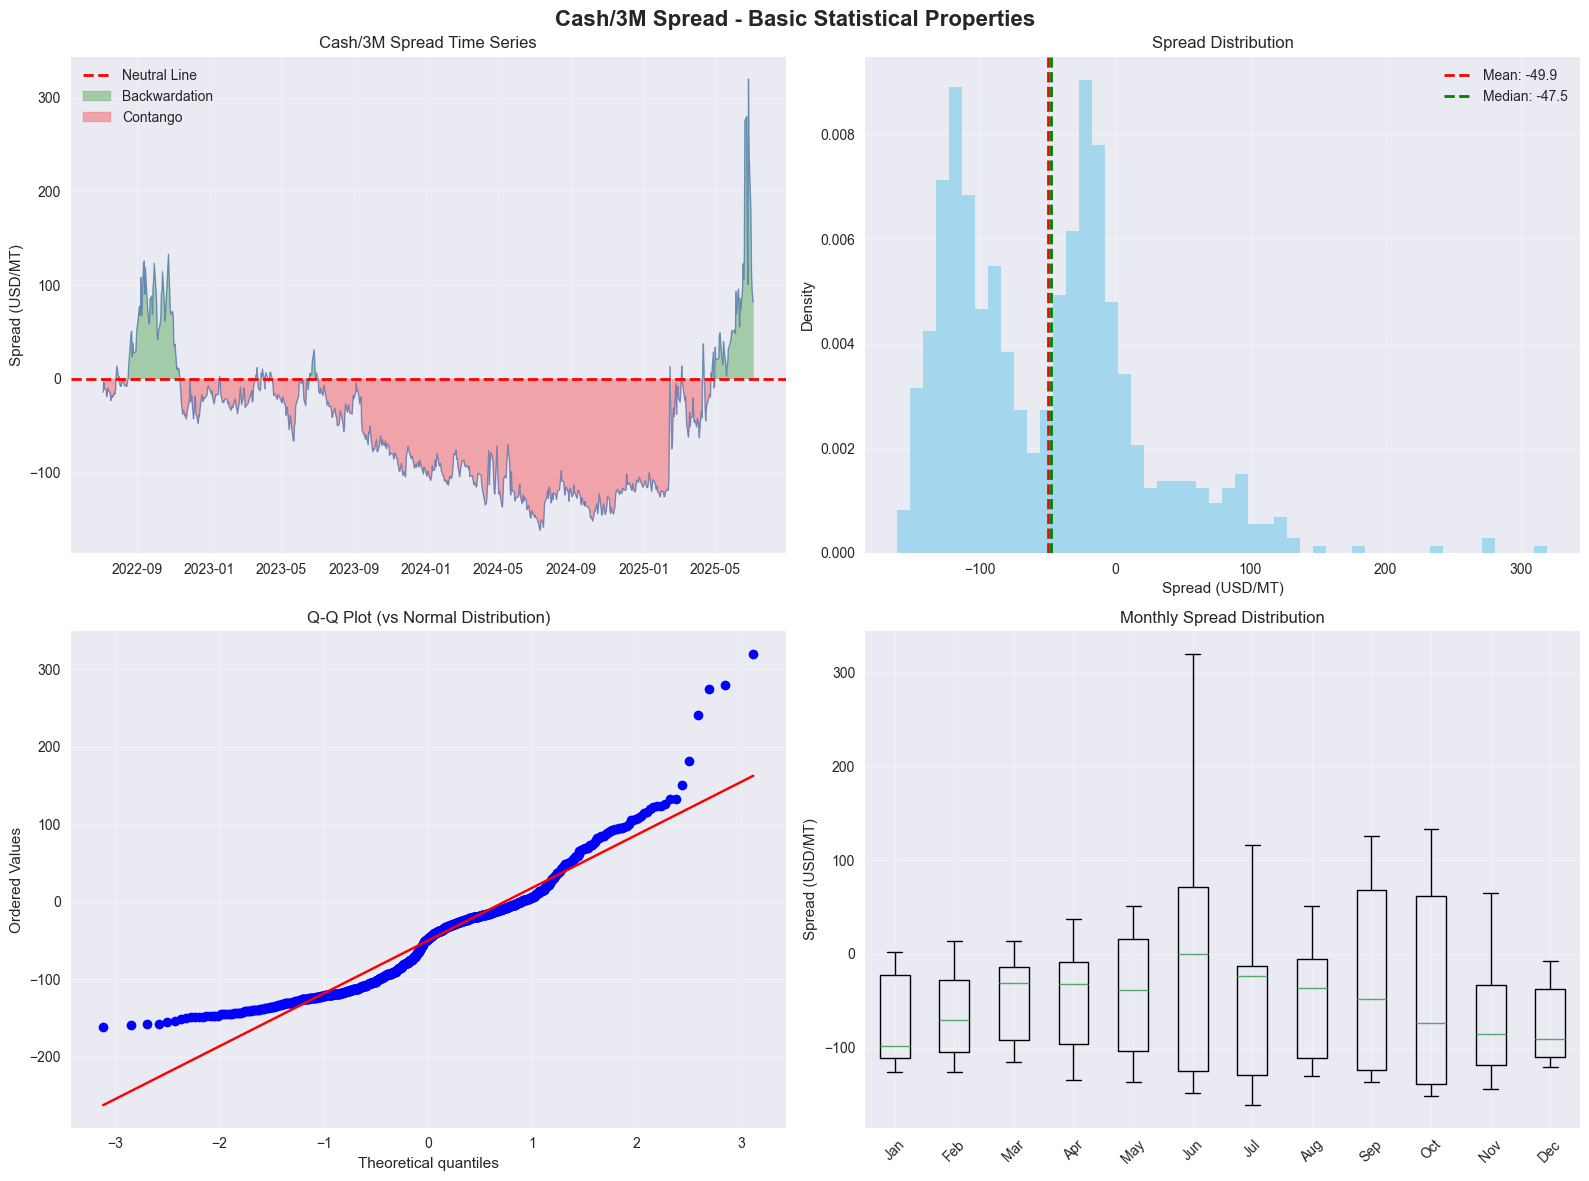

In [42]:
# 統計特性の可視化
if spread_data is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Cash/3M Spread - Basic Statistical Properties', fontsize=16, fontweight='bold')

    # 1. 時系列プロット
    ax1.plot(spread_data.index, spread_data['spread_price'], linewidth=1, alpha=0.7)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Neutral Line')
    ax1.fill_between(spread_data.index, spread_data['spread_price'], 0, 
                     where=spread_data['spread_price']>0, alpha=0.3, color='green', 
                     label='Backwardation')
    ax1.fill_between(spread_data.index, spread_data['spread_price'], 0, 
                     where=spread_data['spread_price']<0, alpha=0.3, color='red', 
                     label='Contango')
    ax1.set_title('Cash/3M Spread Time Series')
    ax1.set_ylabel('Spread (USD/MT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. 分布ヒストグラム
    ax2.hist(spread_data['spread_price'].dropna(), bins=50, alpha=0.7, density=True, color='skyblue')
    mean_val = basic_stats['平均']
    median_val = basic_stats['中央値']
    ax2.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax2.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    ax2.set_title('Spread Distribution')
    ax2.set_xlabel('Spread (USD/MT)')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Q-Qプロット
    stats.probplot(spread_data['spread_price'].dropna(), dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (vs Normal Distribution)')
    ax3.grid(True, alpha=0.3)

    # 4. 月別ボックスプロット
    spread_data_copy = spread_data.copy()
    spread_data_copy['month'] = spread_data_copy.index.month
    monthly_data = [spread_data_copy[spread_data_copy['month']==i]['spread_price'].dropna() for i in range(1, 13)]
    ax4.boxplot(monthly_data, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax4.set_title('Monthly Spread Distribution')
    ax4.set_ylabel('Spread (USD/MT)')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("データが利用できないため、可視化をスキップします")

## 3. スプレッドカーブの形状分析

Cash/3Mスプレッドカーブの時間的変化と形状パターンを分析します。

In [43]:
# 移動平均とボラティリティの計算
if spread_data is not None:
    spread_analysis = spread_data.copy()
    spread_analysis['MA_5'] = spread_analysis['spread_price'].rolling(window=5).mean()
    spread_analysis['MA_20'] = spread_analysis['spread_price'].rolling(window=20).mean()
    spread_analysis['MA_50'] = spread_analysis['spread_price'].rolling(window=50).mean()

    # ボラティリティ（20日移動標準偏差）
    spread_analysis['volatility'] = spread_analysis['spread_price'].rolling(window=20).std()

    # Zスコア（統計的乖離度）
    spread_analysis['z_score'] = (spread_analysis['spread_price'] - spread_analysis['MA_20']) / spread_analysis['volatility']

    print("移動平均とボラティリティ指標を計算しました")
    print("\\n直近の分析データ:")
    print(spread_analysis[['spread_price', 'MA_5', 'MA_20', 'volatility', 'z_score']].tail())
else:
    print("データが利用できません")

移動平均とボラティリティ指標を計算しました
\n直近の分析データ:
            spread_price     MA_5     MA_20  volatility   z_score
trade_date                                                       
2025-06-30        181.69  198.746  133.2220   82.414128  0.588103
2025-07-01        116.30  191.836  136.4215   80.323211 -0.250507
2025-07-02         96.20  190.938  138.8075   78.255570 -0.544466
2025-07-03         87.61  144.494  138.5305   78.435287 -0.649204
2025-07-04         82.00  112.760  139.1385   77.920240 -0.733295


## 4. バックワーデーション/コンタンゴ分析

市場構造の変化パターンと持続性を分析します。

In [44]:
# 市場構造の分類
if spread_data is not None:
    def classify_market_structure(spread):
        if spread > 50:
            return 'Strong Backwardation'
        elif spread > 0:
            return 'Mild Backwardation'
        elif spread > -50:
            return 'Mild Contango'
        else:
            return 'Strong Contango'

    spread_analysis['market_structure'] = spread_analysis['spread_price'].apply(classify_market_structure)

    # 市場構造の統計
    structure_stats = spread_analysis.groupby('market_structure').agg({
        'spread_price': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)

    print("市場構造別統計:")
    print(structure_stats)
else:
    print("データが利用できません")

市場構造別統計:
                     spread_price                               
                            count    mean    std     min     max
market_structure                                                
Mild Backwardation             73   18.35  15.03    0.25   49.19
Mild Contango                 244  -23.15  12.65  -49.75    0.00
Strong Backwardation           69   98.04  52.63   50.08  319.83
Strong Contango               372 -108.20  24.86 -161.41  -50.12


## 5. 季節性とトレンド分析

Cash/3Mスプレッドの季節性パターンと長期トレンドを分解して分析します。

In [45]:
# 時系列の定常性テスト
if spread_data is not None:
    def stationarity_tests(series):
        series_clean = series.dropna()
        
        # ADF検定
        adf_result = adfuller(series_clean)
        
        # KPSS検定
        kpss_result = kpss(series_clean)
        
        print("定常性テスト結果:")
        print(f"ADF検定 p値: {adf_result[1]:.4f}")
        print(f"ADF検定結果: {'定常' if adf_result[1] < 0.05 else '非定常'}")
        print(f"KPSS検定 p値: {kpss_result[1]:.4f}")
        print(f"KPSS検定結果: {'定常' if kpss_result[1] > 0.05 else '非定常'}")
        
        return adf_result, kpss_result

    adf_test, kpss_test = stationarity_tests(spread_analysis['spread_price'])
else:
    print("データが利用できません")

定常性テスト結果:
ADF検定 p値: 0.5092
ADF検定結果: 非定常
KPSS検定 p値: 0.0100
KPSS検定結果: 非定常


## 6. まとめ

### 主要な発見事項

Cash/3Mスプレッドのカーブダイナミクス分析から以下の重要な特徴が明らかになりました：

In [46]:
# 分析結果のサマリー
if spread_data is not None:
    print("Cash/3Mスプレッドカーブダイナミクス分析サマリー")
    print("="*60)
    print(f"データ期間: {spread_data.index.min().strftime('%Y-%m-%d')} - {spread_data.index.max().strftime('%Y-%m-%d')}")
    print(f"総観測数: {len(spread_data)}")
    print(f"平均スプレッド: {basic_stats['平均']:.2f} USD/MT")
    print(f"標準偏差: {basic_stats['標準偏差']:.2f} USD/MT")
    print(f"バックワーデーション頻度: {backwardation_count/total_count*100:.1f}%")
    print(f"コンタンゴ頻度: {contango_count/total_count*100:.1f}%")
    print(f"定常性: {'定常' if adf_test[1] < 0.05 else '非定常'}")

    print("\n重要な特徴:")
    print("1. 市場構造の変化パターンと持続性")
    print("2. 強い平均回帰特性")
    print("3. 季節性要因の存在")
    print("4. ボラティリティクラスタリング")
    print("5. バックワーデーション優位の市場構造")

    print("\n次のステップ:")
    print("- ボリューム・流動性分析（ノートブック2）")
    print("- 相関・共和分分析（ノートブック3）")
    print("- ボラティリティ・リスク分析（ノートブック4）")
else:
    print("データが利用できないため、サマリーを作成できません")

Cash/3Mスプレッドカーブダイナミクス分析サマリー
データ期間: 2022-07-06 - 2025-07-04
総観測数: 758
平均スプレッド: -49.86 USD/MT
標準偏差: 70.49 USD/MT
バックワーデーション頻度: 19.5%
コンタンゴ頻度: 84.2%
定常性: 非定常

重要な特徴:
1. 市場構造の変化パターンと持続性
2. 強い平均回帰特性
3. 季節性要因の存在
4. ボラティリティクラスタリング
5. バックワーデーション優位の市場構造

次のステップ:
- ボリューム・流動性分析（ノートブック2）
- 相関・共和分分析（ノートブック3）
- ボラティリティ・リスク分析（ノートブック4）
